In [16]:
import pandas as pd
import cv2
import numpy as np
import faiss

### COLOR HISTOGRAMS

Read paths

In [17]:
paths_db = pd.read_csv("database/db.csv", index_col=0)
paths = paths_db['image'].values.tolist()
paths = ["images\\" + path for path in paths]

Transformation function

In [18]:
def create_color_histogram(img, bins=8):
    img = np.array(img)

    # Calculate histograms per channel
    hist_r, _ = np.histogram(img[:, :, 0], bins=bins, range=(0, 255))
    hist_g, _ = np.histogram(img[:, :, 1], bins=bins, range=(0, 255))
    hist_b, _ = np.histogram(img[:, :, 2], bins=bins, range=(0, 255))
    
    # Combine histograms into a single vector
    new_vector = []
    for freqR in hist_r:
        for freqG in hist_g:
            for freqB in hist_b:
                new_vector.append(freqR + freqG + freqB)

    return np.array([new_vector], dtype=np.float32)

Application of the function

In [19]:
color_histograms = []
dimension = 512

for path in paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_histogram = create_color_histogram(img).reshape(dimension)
    color_histograms.append(color_histogram)

Creation of the index

In [20]:
index = faiss.IndexFlatL2(dimension)

vectores = np.array(color_histograms)

faiss.normalize_L2(vectores)

index.add(vectores)

In [21]:
faiss.write_index(index, "database/color_histograms.index")

Test

Distances:  [[0.04621241 0.08502715 0.09219266 0.09814082 0.10135792]]
Indices:  [[155 126  71 114 465]]


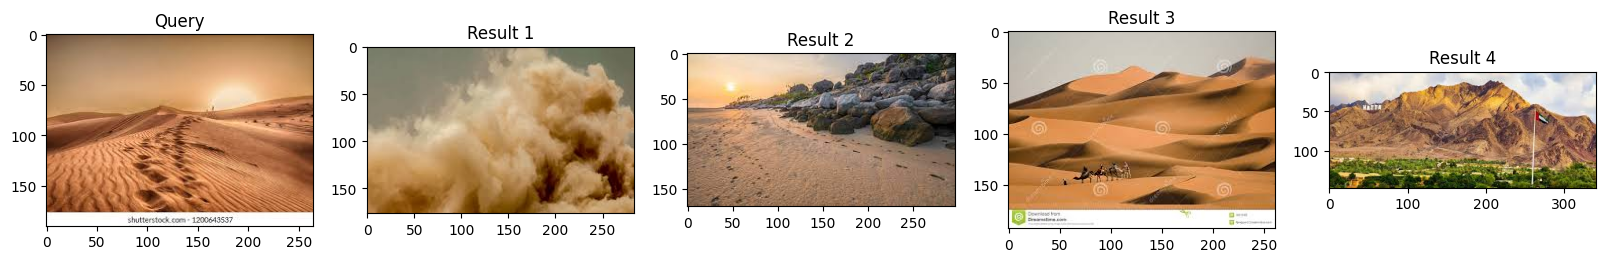

In [25]:
index = faiss.read_index("database/color_histograms.index")

img_test = "images\Testing Data\Desert\Desert-Test (1).jpeg"

img = cv2.imread(img_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

query = create_color_histogram(img).reshape(dimension)

query = np.array([query])

faiss.normalize_L2(query)

k = 5
distances, indices = index.search(query, k)

print("Distances: ", distances)
print("Indices: ", indices)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title("Query")

for i in range(1, k):
    img = cv2.imread(paths[indices[0][i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Result " + str(i))

plt.show()